In [1]:
!pip3 install --upgrade decorator
!pip3 install --upgrade networkx

  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)


### Graphs over different `event_type`: View, Cart, Purchase
The objective for this project is to develop a recommendation system that suggests products related or similar to the one the user is currently browsing.


In [2]:
# Importing libraries and initializing DuckDB connection

import pandas as pd
import numpy as np
import duckdb
import time
import networkx as nx
import matplotlib.pyplot as plt

start = time.time()
con = duckdb.connect(database=':memory:', read_only=False)

In [3]:
# Querying sessions with more than one product view

con.query('''
SELECT 
user_session, 
count(distinct product_id) as count_pdp_views_per_session
FROM '../Data/optimised_raw_data.parquet'
WHERE event_type = 'view'
  AND user_session IS NOT NULL
  AND product_id IS NOT NULL
GROUP BY user_session
HAVING count(distinct product_id) > 1
''').df()

,user_session,count_pdp_views_per_session
0,5de976a3-ec27-4364-ae1e-ccbe2f8c52ce,2
1,78fe8b75-11b8-4301-9bf1-23bd611af33b,2
2,803c3435-765b-4738-8aa9-ca9d6ce1590a,2
3,42f50340-a913-40ae-920d-a9668daf838e,3
4,f15e30a5-7c0b-46c4-a76c-2935ee036a70,17
...,...,...
5340110,a2bba777-c67c-4e52-9de1-5fd228e0cb6e,2
5340111,4f1aac7c-cea7-4219-b730-aca92c8cc3ed,3
5340112,b72301f4-7f8d-4e7a-b758-8f615aa5fb30,2
5340113,d3ca7a4c-d27a-40e6-acce-f68ffeb32b47,3


Observation: There are 7Million+ sessions with more than 1 pdp view and 5M+ are distinct product views.

In [20]:
# Creating a table of product views within multi-view sessions

con.execute('''
CREATE TABLE product_view_tbl AS
SELECT 
user_id,
product_id, 
CAST(event_time[:-3] as DATETIME) as event_time, 
user_session
FROM '../Data/optimised_raw_data.parquet'
WHERE user_session in (SELECT 
user_session
FROM '../Data/optimised_raw_data.parquet'
WHERE event_type = 'view'
  AND user_session IS NOT NULL
  AND product_id IS NOT NULL
GROUP BY user_session
HAVING count(distinct product_id) > 1)
ORDER BY user_session, CAST(event_time[:-3] as DATETIME)
''').df()

In [19]:
con.query("""SELECT *
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8'""").df()

In [22]:
# Querying next viewed product within a session to form edges

sub_graph = con.query("""SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8' """).df()
sub_graph

In [8]:
# Creating a edge list from the query result

edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]
edge_list

[[26201121, 26204318],
 [26204318, 26200951],
 [26200951, 26200951],
 [26200951, 26203272],
 [26203272, 26203272],
 [26203272, 26201124],
 [26201124, 26201124],
 [26201124, 26200344],
 [26200344, 100037882],
 [100037882, 100037882],
 [100037882, 26204653],
 [26204653, 26202732],
 [26202732, 100000092],
 [100000092, -1]]

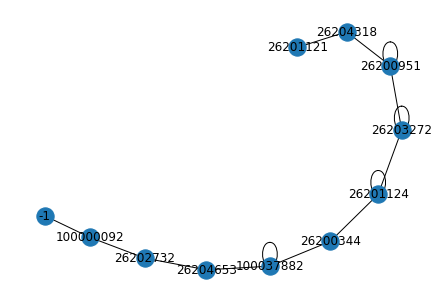

In [9]:
# Visualizing the graph for a single session

G = nx.Graph()
G.add_edges_from(edge_list)
nx.draw(G, with_labels=True)
plt.show()

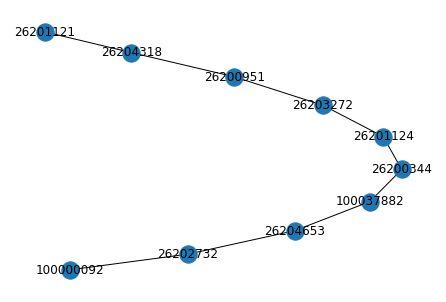

In [10]:
# Query for constructing the full edge list

sub_graph = con.query("""
SELECT * FROM (SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8' ) as A where product_id<>next_viewed_product_id and next_viewed_product_id<>-1""").df()
edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]
G = nx.Graph()
G.add_edges_from(edge_list)
nx.draw(G, with_labels=True)
plt.show()

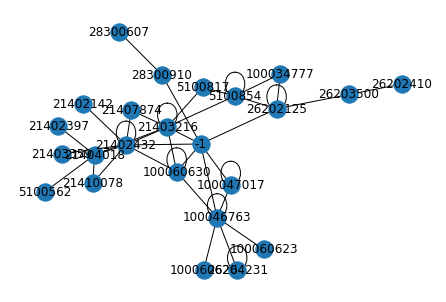

In [11]:
# Displaying a sample from the product views graph

sub_graph = con.query("""SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_id = '518269232'""").df()

edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]
G = nx.Graph()
G.add_edges_from(edge_list)

nx.draw(G, with_labels=True)
plt.show()


In [12]:
%%time
con.execute("""CREATE TABLE product_views_graph AS select product_id, 
LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) as next_viewed_product_id,
user_session,
event_time
from product_view_tbl
""").df()

CPU times: user 6min 11s, sys: 1min 3s, total: 7min 15s
Wall time: 43.1 s


,Count
0,43408767


In [13]:
con.query("""SELECT * FROM product_views_graph LIMIT 15""").df()

,product_id,next_viewed_product_id,user_session,event_time
0,5000427,5000583,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:14:35
1,5000583,5000427,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:15:07
2,5000427,5000427,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:15:19
3,5000427,26021255,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:16:25
4,26021255,26016163,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:19:53
5,26016163,26016163,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:21:39
6,26016163,26016163,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:23:03
7,26016163,26000276,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:23:10
8,26000276,26026427,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:25:31
9,26026427,100074135,000fe336-1fc8-446e-bb12-e7f8bd0c9c58,2020-01-17 05:26:35


### COUNT of Cases: Refresh on Same Product Page

In [31]:
con.query("""SELECT COUNT(*) as page_refresh_count FROM product_views_graph 
WHERE product_id=next_viewed_product_id""").df()

,page_refresh_count
0,12181069


In [15]:
# Constructing a directed graph excluding self-loops and invalid edges

%%time
# Directed Graph Query
directed_graph = con.execute("""SELECT product_id AS pid_1,
       next_viewed_product_id AS pid_2
FROM product_views_graph
WHERE product_id!=next_viewed_product_id
  AND next_viewed_product_id<>-1
""").df()

CPU times: user 509 ms, sys: 125 ms, total: 634 ms
Wall time: 631 ms


In [16]:
len(directed_graph)

25887583

In [17]:
# Saving the directed graph to a parquet file

directed_graph.to_parquet('../Data/ConstructedGraph/raw_unweighted_directed_product_views_graph.parquet',index=False)

In [32]:
directed_graph

,pid_1,pid_2
0,5000427,5000583
1,5000583,5000427
2,5000427,26021255
3,26021255,26016163
4,26016163,26000276
...,...,...
25887578,26203856,26200308
25887579,26200308,26201813
25887580,5100376,5100846
25887581,5100846,1005160


### Directed_Weighted_Product View Graph

In [18]:
# Constructing a directed-weighted graph


%%time
directed_weighted_graph = con.execute("""
SELECT product_id AS pid_1,
       next_viewed_product_id AS pid_2,
       COUNT(*) AS occurence_ct
FROM product_views_graph
WHERE next_viewed_product_id<>-1
  AND product_id IS NOT NULL
  AND product_id != next_viewed_product_id
GROUP BY 1,
         2
""").df()

CPU times: user 9.3 s, sys: 948 ms, total: 10.3 s
Wall time: 1.35 s


In [19]:
directed_weighted_graph

,pid_1,pid_2,occurence_ct
0,1201460,1201389,326
1,100008228,1005135,1
2,13200941,13201188,13
3,1801551,1801636,478
4,1801636,1801881,390
...,...,...,...
8418450,6000092,6000197,1
8418451,6700941,6700915,1
8418452,1004158,15200354,1
8418453,100029639,4700629,1


In [20]:
directed_weighted_graph.to_parquet('../Data/ConstructedGraph/directed_weighted_product_views_graph.parquet',index=False)

### Undirected Weighted Product View Graph

In [21]:
# Constructing an undirected-weighted graph

%%time
undirected_weighted_graph = con.execute("""
SELECT CASE
           WHEN product_id > next_viewed_product_id THEN product_id
           ELSE next_viewed_product_id
       END AS pid_1,
       CASE
           WHEN product_id < next_viewed_product_id THEN product_id
           ELSE next_viewed_product_id
       END AS pid_2,
       COUNT(*) AS occurence_ct
FROM product_views_graph
WHERE next_viewed_product_id<>-1
  AND product_id IS NOT NULL
  AND product_id != next_viewed_product_id
GROUP BY 1,
         2
""").df()

CPU times: user 9.1 s, sys: 816 ms, total: 9.91 s
Wall time: 1.22 s


In [22]:
undirected_weighted_graph

,pid_1,pid_2,occurence_ct
0,2602240,2601962,3
1,12711147,5801656,3
2,7203361,7202724,2
3,12717857,12709938,1
4,12720579,12706441,1
...,...,...,...
6846587,7101405,7101347,1
6846588,100073697,100073489,1
6846589,13300078,12000164,1
6846590,100057594,12600093,1


In [23]:
undirected_weighted_graph.to_parquet('../Data/ConstructedGraph/undirected_weighted_product_views_graph.parquet',index=False)